In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [4]:
df = pd.read_csv('../data/cleaned_telco_customer_churn.csv')
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df = df.drop(['customer_id'], axis=1, errors='ignore')

In [6]:
df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
target_col = "churn"

X = df.drop(columns=[target_col])
y = df[target_col].map({"No": 0, "Yes": 1})

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
from sklearn.impute import SimpleImputer

num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(exclude=[np.number]).columns

In [10]:
print(num_cols)
print(cat_cols)

Index(['senior_citizen', 'tenure', 'monthly_charges', 'total_charges'], dtype='object')
Index(['gender', 'partner', 'dependents', 'phone_service', 'multiple_lines',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'contract', 'paperless_billing', 'payment_method'],
      dtype='object')


In [11]:
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

In [12]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ]
)

In [13]:
from sklearn.linear_model import LogisticRegression

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

clf.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

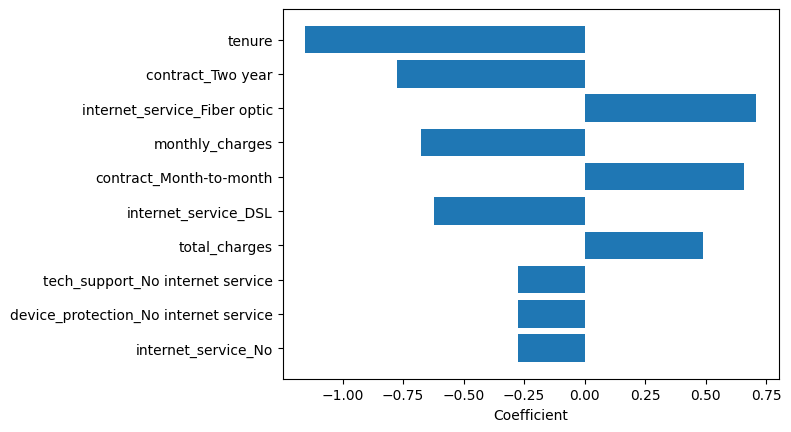

In [27]:
feature_names = (
    list(num_cols) +
    list(clf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot']
         .get_feature_names_out(cat_cols))
)

coefficients = clf.named_steps['model'].coef_[0]

# Visualize top 10 absolute coefficients
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coef': np.abs(coefficients),
    'odds_ratio': np.exp(coefficients)
}).sort_values('abs_coef', ascending=False).head(10)

plt.barh(coef_df['feature'], coef_df['coefficient'])
plt.xlabel('Coefficient')
plt.gca().invert_yaxis()
plt.show()

In [28]:
coef_df

,feature,coefficient,abs_coef,odds_ratio
1,tenure,-1.154434,1.154434,0.315236
38,contract_Two year,-0.775518,0.775518,0.460465
16,internet_service_Fiber optic,0.707981,0.707981,2.029888
2,monthly_charges,-0.676114,0.676114,0.508590
36,contract_Month-to-month,0.657713,0.657713,1.930373
15,internet_service_DSL,-0.622465,0.622465,0.536620
3,total_charges,0.489698,0.489698,1.631823
28,tech_support_No internet service,-0.275403,0.275403,0.759266
25,device_protection_No internet service,-0.275403,0.275403,0.759266
17,internet_service_No,-0.275403,0.275403,0.759266


In [16]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

ROC-AUC: 0.8416388953473353
[[747 288]
 [ 81 293]]
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



In [24]:
threshold = 0.3
y_pred_custom = (y_proba >= threshold).astype(int)

print("ROC-AUC : ", roc_auc_score(y_test, y_proba))
print("\nConfusion Matrix")
print(confusion_matrix(y_test, y_pred_custom))
print("\nClassification Report")
print(classification_report(y_test, y_pred_custom))

ROC-AUC :  0.8416388953473353

Confusion Matrix
[[575 460]
 [ 27 347]]

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.56      0.70      1035
           1       0.43      0.93      0.59       374

    accuracy                           0.65      1409
   macro avg       0.69      0.74      0.65      1409
weighted avg       0.82      0.65      0.67      1409



In [ ]:
import joblib
joblib.dump(clf, '../model/churn_model.pkl')